This notebook demonstrates the fitting routine adapted from the powerlaw module.

In [1]:
import geopandas as gpd
import geopandas as gpd
import os
import re
import pandas as pd
from utils import wildfire_powerlaw as wfpl
import sys

sys.path.append("..")
from utils.landcover_segmentation import load_shapefile

In [7]:
# REPLACE WITH PATH TO MTBS DOWNLOADED DATA
mtbs_gdf = load_shapefile(
    "/Users/lukevonkapff/wildfires/MTBS/S_USA.MTBS_BURN_AREA_BOUNDARY.shp",
    "EPSG:4269",
    area_col="AREA_SQKM"
)
data = mtbs_gdf["AREA_SQKM"].dropna().to_numpy()

In [8]:
params = wfpl.summarize_parameters_bootstrap(data, R=10, xmin = 4, random_state=42)
params

there are 25256 points above xmin 4.0 km^2


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,p1,p1_se,p2,p2_se,reduces_to
distribution,,,,,
exponential,3.339459e-02,1.182075e-03,NaN,NaN,NaN
generalized_pareto,9.837063e-01,1.650807e-02,5.731043e+00,7.338442e-02,NaN
lognormal,-4.335098e+00,5.595107e-01,3.048478e+00,1.147265e-01,NaN
lognormal_excess,2.568364e+00,9.396175e-03,1.064351e+00,1.091066e-02,NaN
power_law,1.845974e+00,6.750927e-03,NaN,NaN,NaN
stretched_exponential,1.550625e+06,1.242077e+06,1.176361e-01,5.393297e-03,NaN
truncated_power_law,1.769501e+00,9.511472e-03,7.729050e-04,9.839658e-05,NaN
weibull,1.127603e-01,3.331657e-03,2.123427e-07,2.787043e-07,NaN
weibull_excess,7.103422e-01,8.052095e-03,2.365892e+01,3.512230e-01,NaN


In [9]:
R, best = wfpl.likelihood_matrix_and_best(data, xmin = 4)
print("Best-fitting distribution:", best)
R

Best-fitting distribution: weibull


,Δloglik vs weibull
weibull,0.000000
lognormal,0.379558
stretched_exponential,1.062564
truncated_power_law,2.839540
generalized_pareto,3.040797
power_law,155.277876
lognormal_excess,4471.365005
weibull_excess,8104.487689
exponential,16918.836523


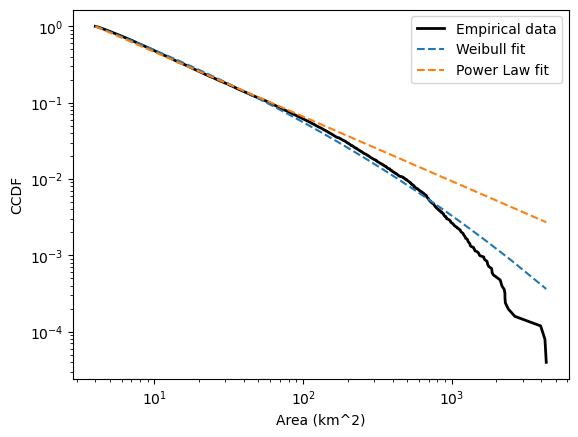

In [10]:
ax = wfpl.plot_ccdf_with_selected_fits(
    data, xmin=4, which = ['weibull', 'power_law']
)

Verify that the fitting routine yields similar results when applied to the region in time and space where all 3 datasets overlap.

In [11]:
# REPLACE WITH MTBS DOWNLOADED DATA PATH
mtbs_gdf = gpd.read_file("/Users/lukevonkapff/wildfires/MTBS/S_USA.MTBS_BURN_AREA_BOUNDARY.shp")
mtbs_gdf = mtbs_gdf.set_crs("EPSG:4269")
mtbs_proj = mtbs_gdf.to_crs("EPSG:6933")

# REPLACE WITH IDAHO DOWNLOADED DATA PATH
idaho_gdf = gpd.read_file("/Users/lukevonkapff/wildfires/ID_HFDB/HFD_HistoricFiresDatabase7_0.gdb", layer="Fires1950_Present")
idaho_gdf = idaho_gdf.to_crs("EPSG:6933")

mtbs_proj = mtbs_proj[(mtbs_proj["YEAR"] >= 2003) & (mtbs_proj["YEAR"] <= 2016)]
idaho_gdf = idaho_gdf[(idaho_gdf["FIRE_YEAR"] >= 2003) & (idaho_gdf["FIRE_YEAR"] <= 2016)]

mtbs_proj["area_km2"] = mtbs_proj.geometry.area / 1e6
idaho_gdf["area_km2"] = idaho_gdf.geometry.area / 1e6

mtbs_overlap = gpd.sjoin(mtbs_proj, idaho_gdf[["geometry"]], predicate="intersects")
mtbs_overlap = mtbs_overlap.drop_duplicates(subset="FIRE_ID")

# REPLACE WITH GFA DOWNLOADED DATA PATH
folder_path = "/Users/lukevonkapff/wildfires/CMS_GFA/data"
pattern = re.compile(r"Global_fire_atlas_V1_perimeter_\d{4}")

gfa_all_data = []

for gfa_folder_name in os.listdir(folder_path):
    if pattern.match(gfa_folder_name):
        gfa_folder_path = os.path.join(folder_path, gfa_folder_name)
        if os.path.isdir(gfa_folder_path):
            gfa_shp_path = os.path.join(gfa_folder_path, gfa_folder_name + ".shp")
            if os.path.exists(gfa_shp_path):
                print(f"Processing {gfa_shp_path} ...")
                gfa_gdf = gpd.read_file(gfa_shp_path)
                
                gfa_gdf = gfa_gdf.set_crs("EPSG:4326")
                gfa_gdf = gfa_gdf.to_crs("EPSG:6933")
                
                gfa_gdf["area_km2"] = gfa_gdf.geometry.area / 1e6
                gfa_gdf["perim_km"] = gfa_gdf.geometry.length / 1000

                gfa_year = int(re.search(r"\d{4}", gfa_folder_name).group())
                gfa_gdf["YEAR"] = gfa_year
                gfa_all_data.append(gfa_gdf)

gfa_combined_gdf = gpd.GeoDataFrame(pd.concat(gfa_all_data, ignore_index=True), crs="EPSG:6933")

gfa_overlap = gpd.sjoin(gfa_combined_gdf, idaho_gdf[["geometry"]], predicate="intersects")
gfa_overlap = gfa_overlap.drop_duplicates(subset="geometry")

/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiPolygon' is converted to 'MultiPolygon Z'
  return ogr_read(
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2005/Global_fire_atlas_V1_perimeter_2005.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2004/Global_fire_atlas_V1_perimeter_2004.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2003/Global_fire_atlas_V1_perimeter_2003.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2010/Global_fire_atlas_V1_perimeter_2010.shp ...


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2010/Global_fire_atlas_V1_perimeter_2010.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp ...


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2011/Global_fire_atlas_V1_perimeter_2011.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2006/Global_fire_atlas_V1_perimeter_2006.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2008/Global_fire_atlas_V1_perimeter_2008.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2009/Global_fire_atlas_V1_perimeter_2009.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2007/Global_fire_atlas_V1_perimeter_2007.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2014/Global_fire_atlas_V1_perimeter_2014.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2013/Global_fire_atlas_V1_perimeter_2013.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_f

In [12]:
mtbs_data = mtbs_overlap['area_km2'].dropna().to_numpy()
gfa_data = gfa_overlap['area_km2'].dropna().to_numpy()
id_data = idaho_gdf['area_km2'].dropna().to_numpy()


mtbs_params = wfpl.summarize_parameters_bootstrap(mtbs_data, R=10, xmin = 4, random_state=42)
gfa_params = wfpl.summarize_parameters_bootstrap(gfa_data, R=10, xmin = 4, random_state=42)
id_params = wfpl.summarize_parameters_bootstrap(id_data, R=10, xmin = 4, random_state=42)

mtbs_R, mtbs_best = wfpl.likelihood_matrix_and_best(mtbs_data, xmin = 4)
gfa_R, gfa_best = wfpl.likelihood_matrix_and_best(gfa_data, xmin = 4)
id_R, id_best = wfpl.likelihood_matrix_and_best(id_data, xmin = 4)

mtbs_params, gfa_params, id_params

/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 4235 points above xmin 4.0 km^2


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 3728 points above xmin 4.0 km^2


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


there are 4230 points above xmin 4.0 km^2


(                              p1     p1_se         p2     p2_se  reduces_to
 distribution                                                               
 exponential             0.023806  0.001051        NaN       NaN         NaN
 generalized_pareto      1.003759  0.025782   9.036499  0.344311         NaN
 lognormal               0.470887  0.259926   2.203023  0.082501         NaN
 lognormal_excess        2.849872  0.017670   1.171108  0.012746         NaN
 power_law               1.683257  0.008148        NaN       NaN         NaN
 stretched_exponential  11.208864  9.421208   0.220500  0.013565         NaN
 truncated_power_law     1.494358  0.022584   0.001688  0.000253         NaN
 weibull                 0.220487  0.013564   0.089159  0.056940         NaN
 weibull_excess          0.704856  0.011925  32.690315  0.711191         NaN,
                              p1     p1_se         p2     p2_se  reduces_to
 distribution                                                              


In [13]:
mtbs_R, gfa_R, id_R

(                       Δloglik vs stretched_exponential
 stretched_exponential                      0.000000e+00
 weibull                                    5.991242e-07
 lognormal                                  1.866390e+00
 truncated_power_law                        1.040779e+01
 generalized_pareto                         1.943171e+01
 power_law                                  1.283580e+02
 lognormal_excess                           4.853418e+02
 weibull_excess                             9.353356e+02
 exponential                                2.276048e+03,
                        Δloglik vs stretched_exponential
 stretched_exponential                      0.000000e+00
 weibull                                    2.488559e-08
 lognormal                                  1.288911e+00
 truncated_power_law                        1.676290e+01
 generalized_pareto                         1.832805e+01
 power_law                                  1.385950e+02
 lognormal_excess             

Close relative performance of different distributions on all 3 datasets!